# Fast WRMSSE Evaluator with extra features

Here I try to make implementation of `WRMSSEEvaluator` faster from amazing notebook [WRMSSE Evaluator with extra features](https://www.kaggle.com/dhananjay3/wrmsse-evaluator-with-extra-features) by applying matrix multiplication for hierarchical aggregation from this wonderful notebook: [Fast & Clear WRMSSE 18ms](https://www.kaggle.com/sibmike/fast-clear-wrmsse-18ms)


|         |            |  |
| ------------- |:-------------:| -----:|
| WRMSSEEvaluator | ~15.1 s | ~15100 ms |
| This notebook, FastWRMSSEEvaluator | ~0.21 s      |   ~214 ms |


It could be improved further to get to 18 ms, but if you don't use evaluator as a loss function, there is no a lot of difference between 18 ms and 166 ms.

**Version 5**: Fix bug with indexing of validation predictions. Need to clean up and double check

_Note: Below I use some test to verify that this implementation is correct, but encourage you to double check. Apppreciate your feedback!_


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
%%time

train_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

train_fold_df = train_df.iloc[:, :-28]
valid_fold_df = train_df.iloc[:, -28:]

In [ ]:
from typing import Union

import numpy as np
import pandas as pd
from tqdm.auto import tqdm as tqdm

class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)


In [ ]:
from typing import Union

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from tqdm.auto import tqdm as tqdm


class FastWRMSSEEvaluator(object):

    group_ids = ('all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
                 ['state_id', 'cat_id'], ['state_id', 'dept_id'], ['store_id', 'cat_id'],
                 ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self,
                 train_df: pd.DataFrame,
                 valid_df: pd.DataFrame,
                 calendar: pd.DataFrame,
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        val_cols = set(self.valid_df.columns)
        val_col_diff = set(self.id_columns) - val_cols
        if val_col_diff != set():
            self.valid_df = pd.concat([self.train_df[val_col_diff], self.valid_df],
                                      axis=1,
                                      sort=False)

        self.valid_df = self.valid_df.sort_values(by='id').reset_index()
        self.train_df = self.train_df.sort_values(by='id').reset_index()
        summing_matrix = self.create_summing_matrix(self.valid_df.sort_values(by='id').reset_index(), self.group_ids)
        summing_matrix = summing_matrix.reindex(sorted(summing_matrix.columns), axis=1)
        self.summing_index = summing_matrix.index
        self.summing_matrix = csr_matrix(summing_matrix)

        self.train_series = self.trans_30490_to_42840(self.train_df,
                                                      self.train_target_columns,
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df,
                                                      self.valid_target_columns,
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series != 0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)

    def get_name(self, i):
        '''
        convert a str or list of strings to unique string
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)

    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def create_summing_matrix(self, df, aggregation_levels):
        # we are going to alter this, so copy it
        aggregation_levels = [x for x in aggregation_levels]

        for i, agg_cols in enumerate(aggregation_levels):
            if type(agg_cols) is list:
                new_col_name = "_".join(agg_cols)

                df[new_col_name] = df[agg_cols[0]]
                for c in agg_cols[1:]:
                    df[new_col_name] += "--" + df[c]
                aggregation_levels[i] = new_col_name

        dummies = [pd.get_dummies(df[agg_cols], drop_first=False,
                                  dtype=np.int8).T for agg_cols in aggregation_levels]
        matrix = pd.concat(dummies)

        return matrix

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        summed_values = self.summing_matrix@df.sort_index()[cols].values.astype(np.float32)
        return pd.DataFrame(summed_values, columns=cols, index=self.summing_index)

    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def validate_valid_preds(self, valid_preds):
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape
        assert set(self.valid_df['id'].values) == set(valid_preds.index.values)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns, index=self.valid_df.set_index('id').index)
        # tweak: use join instead of concat
        # to be safe..
        valid_preds = self.valid_df\
            .set_index('id')[set(self.id_columns) - set(['id'])]\
            .join(valid_preds)\
            .sort_index()\
            .reset_index()
        #         valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
        #                                 axis=1,
        #                                 sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds,
                                                self.valid_target_columns,
                                                self.group_ids,
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse],
                                      axis=1,
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)


# Speed comparison

In [ ]:
%%time
e = WRMSSEEvaluator(train_fold_df.copy(), valid_fold_df.copy(), calendar, prices)

In [ ]:
%%time
fast_e = FastWRMSSEEvaluator(train_fold_df.copy(), valid_fold_df.copy(), calendar, prices)

In [ ]:
valid_preds = np.random.randint(4, size=valid_fold_df.shape)

In [ ]:
%%timeit -n 100 -r 5
# n - execute the statement n times 
# r - repeat each loop r times and return the best

fast_score = fast_e.score(valid_preds)

In [ ]:
%%timeit -n 3 -r 3
# n - execute the statement n times 
# r - repeat each loop r times and return the best

score = e.score(valid_preds)

# Summing matrix overview

Quote from [Forecasting: Principles and Practice](https://otexts.com/fpp2/hts.html)

These equations can be thought of as aggregation constraints or summing equalities, and can be more efficiently represented using matrix notation. We construct an  `n×m` matrix **S** (referred to as the “summing matrix”) which dictates the way in which the bottom-level series are aggregated.

Sample hierarchy:

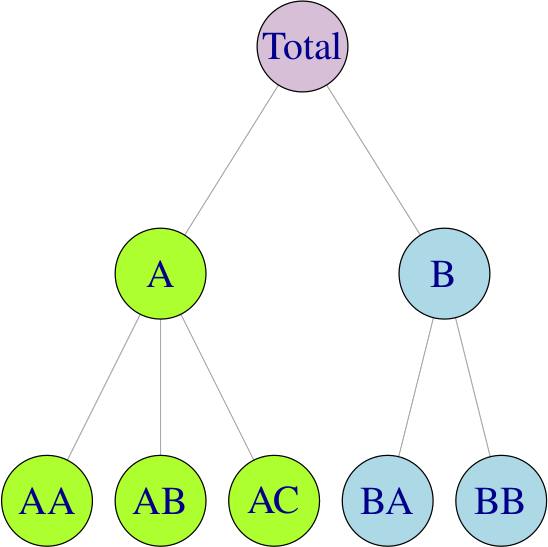


Aggregation matrix for this hierarchy:


$$
\begin{bmatrix}
    y_{t} \\
    y{A}{t} \\
    y{B}{t} \\
    y{AA}{t} \\
    y{AB}{t} \\
    y{AC}{t} \\
    y{BA}{t} \\
    y{BB}{t}
  \end{bmatrix}
  =
  \begin{bmatrix}
    1 & 1 & 1 & 1 & 1 \\
    1 & 1 & 1 & 0 & 0 \\
    0 & 0 & 0 & 1 & 1 \\
    1  & 0  & 0  & 0  & 0  \\
    0  & 1  & 0  & 0  & 0  \\
    0  & 0  & 1  & 0  & 0  \\
    0  & 0  & 0  & 1  & 0  \\
    0  & 0  & 0  & 0  & 1
  \end{bmatrix}
  \begin{bmatrix}
    y{AA}{t} \\
    y{AB}{t} \\
    y{AC}{t} \\
    y{BA}{t} \\
    y{BB}{t}
  \end{bmatrix}
$$

or in more compact notation
$$
\begin{equation}
  \textbf{y}_t=\textbf{S}\textbf{b}_{t}
\end{equation}
$$



# Difference from original version

Method `trans_30490_to_42840` for aggregating top levels of time-series hierarchy used python loop + `groupby`, that is quite slow:


```python
def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
    '''
    transform 30490 sries to all 42840 series
    '''
    series_map = {}
    for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
        tr = df.groupby(group_id)[cols].sum()
        for i in range(len(tr)):
            series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
    return pd.DataFrame(series_map).T
```

Now it uses matrix multiplication:
```python
def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
    '''
    transform 30490 sries to all 42840 series
    '''
    summed_values = self.summing_matrix@df.sort_index()[cols].values.astype(np.int32)
    return pd.DataFrame(summed_values, columns=cols, index=self.summing_index)
```

Summing matrix is initalized with this method:

```python
def create_summing_matrix(self, df, aggregation_levels):
    # we are going to alter this, so copy it
    aggregation_levels = [x for x in aggregation_levels]

    for i, agg_cols in enumerate(aggregation_levels):
        if type(agg_cols) is list:
            new_col_name = "_".join(agg_cols)

            df[new_col_name] = df[agg_cols[0]]
            for c in agg_cols[1:]:
                df[new_col_name] += "--" + df[c]
            aggregation_levels[i] = new_col_name

    dummies = [pd.get_dummies(df[agg_cols], drop_first=False,
                              dtype=np.int8).T for agg_cols in aggregation_levels]
    matrix = pd.concat(dummies)

    return matrix
```

And then transformed to sparse matrix for reducing memory usage and speed:

```python
summing_matrix = self.create_summing_matrix(self.valid_df, self.group_ids)
summing_matrix = summing_matrix.reindex(sorted(summing_matrix.columns), axis=1)
self.summing_index = summing_matrix.index
self.summing_matrix = csr_matrix(summing_matrix)
```

# Verify implementation correctness

## Compare with original evaluator

Here we verify that scores are the same on different random predictions

In [ ]:
valid_preds = np.random.randint(4, size=valid_fold_df.shape)
test_sub = pd.DataFrame(valid_preds, columns=e.valid_target_columns, index=e.valid_df['id'].values)
score, fast_score = e.score(test_sub.values), fast_e.score(test_sub)
print(score, fast_score)
assert np.isclose(score, fast_score)

In [ ]:
valid_preds = np.random.randint(3, size=valid_fold_df.shape)
test_sub = pd.DataFrame(valid_preds, columns=e.valid_target_columns, index=e.valid_df['id'].values)
score, fast_score = e.score(test_sub.values), fast_e.score(test_sub)
print(score, fast_score)
assert np.isclose(score, fast_score)

In [ ]:
valid_preds = np.random.randint(2, size=valid_fold_df.shape)
test_sub = pd.DataFrame(valid_preds, columns=e.valid_target_columns, index=e.valid_df['id'].values)
score, fast_score = e.score(test_sub.values), fast_e.score(test_sub)
print(score, fast_score)
assert np.isclose(score, fast_score)

In [ ]:
np.allclose(fast_e.contributors, e.contributors)

In [ ]:
np.allclose(fast_e.rmsse, e.rmsse)

In [ ]:
very_bad_preds = np.random.randint(30, size=valid_fold_df.shape)

test_sub = pd.DataFrame(very_bad_preds, columns=e.valid_target_columns, index=e.valid_df['id'].values)
score, fast_score = e.score(test_sub.values), fast_e.score(test_sub)
print(score, fast_score)
assert np.isclose(score, fast_score)